In [2]:
#Create word vectors from game of thrones dataset
#GOAL: analyse and see semantic similarity
from __future__ import absolute_import, division, print_function
#for word encoding
import codecs
#regex
import glob
#concurrency
import multiprocessing
#dealing with operating system
import os
#pretty printing
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#Word 2 vec
import gensim.models.word2vec as  w2v
#dimensionality reduction
import sklearn.manifold

import numpy as np
#plotting
import matplotlib.pyplot as plt
#visualisation
import seaborn as sns

import pandas as pd

In [3]:
#STEP 1: Preprocess the data
#Clean data
nltk.download('punkt') #pretrained tokenizer
nltk.download('stopwords') #stopwords

[nltk_data] Downloading package punkt to /home/ken/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
book_filenames = sorted(glob.glob("*.txt"))
book_filenames

['got.txt']

In [59]:
corpus =u""
with codecs.open('got.txt', 'r', 'utf-8') as book_file:
    corpus += book_file.read()
    print (f'Corpus is {len(corpus)} characters long')

Corpus is 4071040 characters long


In [6]:
with open('got.txt') as corpus:
    doc = corpus.read()
    print (len(doc))

4071040


In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [8]:
raw_sentences = tokenizer.tokenize(doc)

In [9]:
#Convert into a list of words
#split into words no hyphens
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words
    

In [10]:
#Sentence where each word is tokenized
sentences =[]
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [11]:
print (raw_sentences[20])
print (sentence_to_wordlist(raw_sentences[20]))

He wondered if his gargoyles had ever seen its like.
['He', 'wondered', 'if', 'his', 'gargoyles', 'had', 'ever', 'seen', 'its', 'like']


In [12]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 763,807 tokens


In [13]:
#Dimensionality of the resulting word vectors
#The greater the number of dimensions the greater the computation expense
num_features = 300

#Minimum word_count 
min_word_count = 3

#No of threads to run in parallel
#More workers,faster training
num_workers = multiprocessing.cpu_count()

#Context window length
context_size = 7

#Downsampling for frequently occuring words
downsampling = 1e-3

#Seeding for reproducable results
seed = 1


In [14]:
thrones2vec = w2v.Word2Vec(sg=1,
                           seed=seed,
                           workers = num_workers,
                           size = num_features,
                           min_count = min_word_count,
                           window = context_size, 
                           sample = downsampling
                          )

In [15]:
thrones2vec.build_vocab(sentences)

In [16]:
print ("Word2Vec Vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec Vocabulary length: 11048


In [17]:
#Training
model = thrones2vec
thrones2vec.train(sentences,total_examples=model.corpus_count, epochs=model.iter)

/home/ken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(2915278, 3819035)

In [20]:
#Saving the model
if not os.path.exists("trained"):
    os.makedirs("trained")

In [21]:
thrones2vec.save(os.path.join("trained","thrones2vec.w2v"))

In [22]:
#Exploring the trained model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained","thrones2vec.w2v"))

In [23]:
#Dimensionality reduction
tsne = sklearn.manifold.TSNE(n_components =2, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/home/ken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [29]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [30]:
points.head(10)

,word,x,y
0,This,-29.057753,-43.289547
1,edition,57.969730,-46.299843
2,the,-15.944350,4.636712
3,complete,40.003033,-16.746370
4,of,-11.771211,5.307925
5,hardcover,56.374599,-41.570889
6,A,-26.281271,-12.457950
7,OF,58.960636,-50.143753
8,KINGS,58.061665,-45.694946
9,Bantam,58.341736,-47.557423


In [32]:
points[15:25]

,word,x,y
15,a,-26.308210,-12.579028
16,boxed,54.051521,-38.550919
17,s,15.961383,-43.806789
18,are,-43.868683,-49.804985
19,trademarks,54.071514,-38.722916
20,Books,54.263508,-38.985226
21,Random,54.144478,-39.207535
22,House,38.313438,-61.220760
23,Inc,54.111469,-39.560005
24,All,-18.457811,-40.632381


In [33]:
sns.set_context('poster')

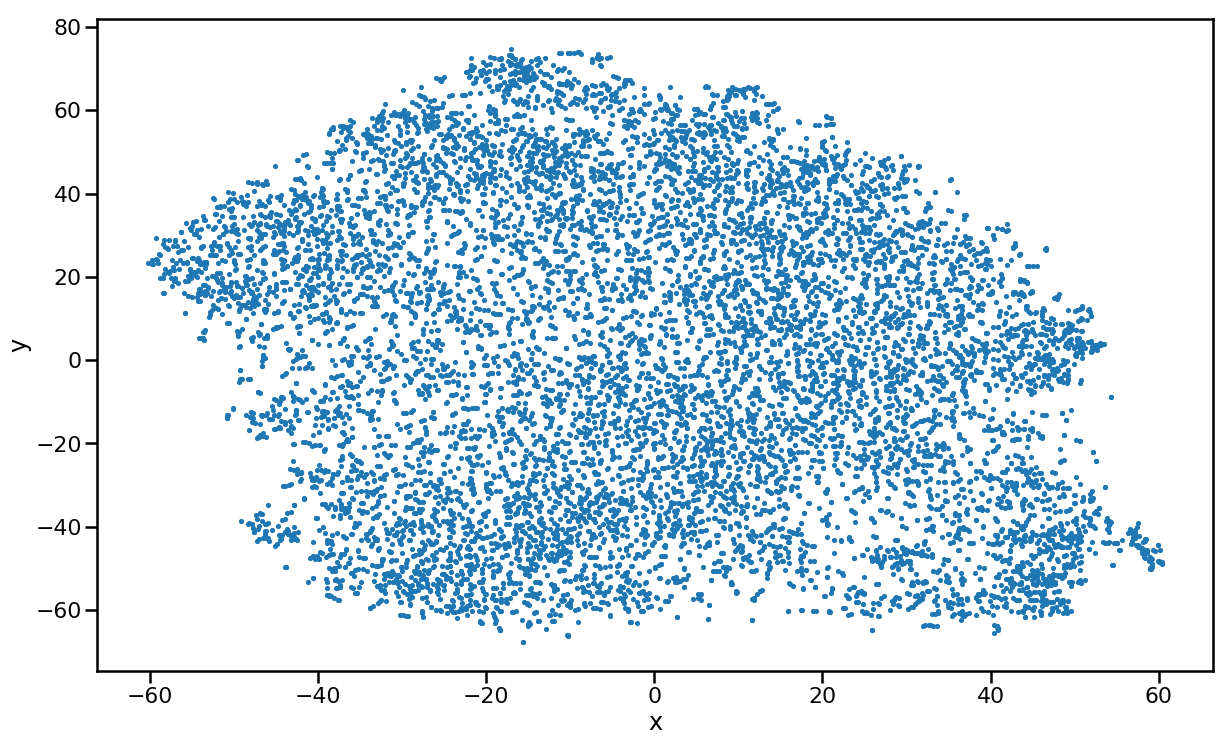

In [34]:
points.plot.scatter("x","y", s=10, figsize=(20,12))

In [35]:
#Zoom to interesting points
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

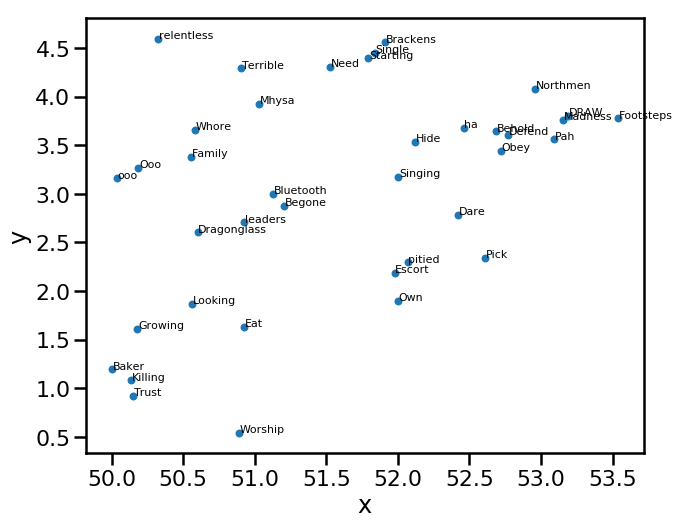

In [43]:
plot_region(x_bounds=(50.0, 60.0), y_bounds=(0.5,5.0))

In [51]:
thrones2vec.wv.most_similar('Stark')

[('Eddard', 0.859982430934906),
 ('Ned', 0.8035975694656372),
 ('Winterfell', 0.7955672144889832),
 ('Arryn', 0.790104866027832),
 ('Eyrie', 0.7807222008705139),
 ('Brandon', 0.7761220932006836),
 ('Benjen', 0.7760553956031799),
 ('betrothed', 0.7475378513336182),
 ('Tully', 0.7433393001556396),
 ('Robb', 0.7431708574295044)]

In [52]:
thrones2vec.wv.most_similar('Daenerys')

[('Stormborn', 0.9548279643058777),
 ('Master', 0.9236345291137695),
 ('Doran', 0.8950093984603882),
 ('mocked', 0.8915945291519165),
 ('history', 0.891364574432373),
 ('Unburnt', 0.890920877456665),
 ('grieving', 0.8907074332237244),
 ('incest', 0.8892772197723389),
 ('grandson', 0.886357307434082),
 ('convinced', 0.8859093189239502)]

In [55]:
thrones2vec.wv.most_similar('dragon')

[('kraken', 0.7933025360107422),
 ('demon', 0.7727019190788269),
 ('lion', 0.7717410326004028),
 ('brass', 0.7614235281944275),
 ('device', 0.7580612897872925),
 ('harpy', 0.7569398283958435),
 ('field', 0.7536879777908325),
 ('jewels', 0.753455638885498),
 ('veins', 0.7531294822692871),
 ('ship', 0.7505203485488892)]

In [56]:
#Linear relationships between word pairs
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [57]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as Tyrion is related to wine
Arya is related to Nymeria, as Dany is related to dragons


'Dany'